## training with one hidden layer

$$
  z_i = S(u_i) \\
  u_i = w_{ij} z_j \\
  z_j = S(u_j) \\
  u_j = w_{jk} z_k \\
  z_k = S(u_k) \\
  u_k = w_{kl} z_l
$$

$$
  \frac{\partial E}{\partial w_{ij}}
  = \frac{\partial E}{\partial z_i} \cdot \frac{\partial z_i}{\partial u_i} \cdot \frac{\partial u_i}{\partial w_{ij}} = (z_i - t_i) \cdot z_i (1 - z_i) \cdot z_j
  = \frac{\partial E}{\partial u_i} \cdot z_j \\
  \frac{\partial E}{\partial w_{jk}} =
  \frac{\partial E}{\partial z_i} \cdot
  \frac{\partial z_i}{\partial u_i} \cdot
  \frac{\partial u_i}{\partial z_j} \cdot
  \frac{\partial z_j}{\partial u_j} \cdot
  \frac{\partial u_j}{\partial w_{jk}}
  = \frac{\partial E}{\partial u_i} \cdot w_{ij} \cdot z_j (1 - z_j) \cdot z_k
  = \frac{\partial E}{\partial u_j} \cdot z_k \\
  \frac{\partial E}{\partial w_{kl}} =
  \frac{\partial E}{\partial z_i} \cdot
  \frac{\partial z_i}{\partial u_i} \cdot
  \frac{\partial u_i}{\partial z_j} \cdot
  \frac{\partial z_j}{\partial u_j} \cdot
  \frac{\partial u_j}{\partial z_k} \cdot
  \frac{\partial z_k}{\partial u_k} \cdot
  \frac{\partial u_k}{\partial w_{kl}}
  = \frac{\partial E}{\partial u_j} \cdot w_{jk} \cdot z_k (1 - z_k) \cdot z_l
  = \frac{\partial E}{\partial u_k} \cdot z_l
$$

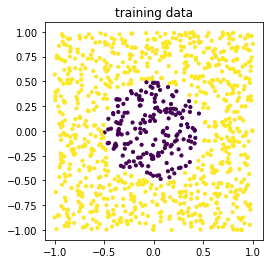

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import graphviz

ALPHA     = 1.0e-1
BATCHSIZE = 5
MAX_EPOCH = 2000
OUT_EPOCH = 50
TYPE      = "circle" # x, circle, stripe, chess, diagonal, occ (off-centered-circle), sin

url = "https://raw.githubusercontent.com/daiki-matsunaga/MathMeasurement/main/lec06/data/"

def Sigmoid(vec):
    return 1.0/(1.0 + np.exp(-vec))

class FeedForward():
    def __init__(self):
        np.random.seed(1) # set random seed

        self.data    = np.loadtxt(url + TYPE + "/training.dat") # read data
        self.numData = self.data.shape[0]                       # number of data
#        self.numData = 500                                      # number of data
        self.l2      = []                                       # l2 time history

        self.num_i = 1  # number of output layer
        self.num_j = 4  # number of hidden layer 1
        self.num_k = 4  # number of hidden layer 2
        self.num_l = 2  # number of input layer

        # set random weight
        self.w_ij = np.random.normal(0.0, 5.0, (self.num_i, self.num_j))
        self.w_jk = np.random.normal(0.0, 5.0, (self.num_j, self.num_k))
        self.w_kl = np.random.normal(0.0, 5.0, (self.num_k, self.num_l))

        # show training data
        fig, ax = plt.subplots()
        ax.scatter(self.data[:self.numData, 0], self.data[:self.numData, 1], c=self.data[:self.numData, 2], s = 10.0)
        ax.set_aspect('equal')
        ax.set_title('training data')
        plt.show()

    def Forward(self, zl):
        zk = Sigmoid(self.w_kl@zl)  # layer l -> layer k
        zj = Sigmoid(self.w_jk@zk)  # layer k -> layer j
        zi = Sigmoid(self.w_ij@zj)  # layer j -> layer i (output layer)
        return zi, zj, zk, zl

    def UpdateWeight(self):
        l2 = 0.0 # initialize L2 error

        # initialize derivatives 
        d_w_ij = np.zeros([self.num_i, self.num_j])
        d_w_jk = np.zeros([self.num_j, self.num_k])
        d_w_kl = np.zeros([self.num_k, self.num_l])

        for idd in range(self.numData): 
            zi, zj, zk, zl = self.Forward([self.data[idd, 0], self.data[idd, 1]]) # forward propagation
            ti = self.data[idd, 2]                                                # read test data
            l2 += (zi - ti)**2.0/self.numData                                     # calculate l2 error

            # backward propagation
            e_ui = (zi - ti)*zi*(1.0 - zi) 
            e_uj = e_ui*self.w_ij[0]*zj*(1.0 - zj)
            e_uk = np.einsum('j,jk->k', e_uj, self.w_jk)*zk*(1.0 - zk)

            d_w_ij += e_ui*zj
            d_w_jk += np.einsum('j,k->jk', e_uj, zk)
            d_w_kl += np.einsum('k,l->kl', e_uk, zl)
            
            # update with batch size
            if (idd + 1)%BATCHSIZE == 0: 
                self.w_ij -= ALPHA*d_w_ij
                self.w_jk -= ALPHA*d_w_jk
                self.w_kl -= ALPHA*d_w_kl
                
                d_w_ij.fill(0.0)
                d_w_jk.fill(0.0)
                d_w_kl.fill(0.0)

        self.l2.append(l2)
        return l2


ml = FeedForward() # constructor

### training

Epoch     0 - L2 error: 3.889423e-01
Epoch    50 - L2 error: 9.284789e-02
Epoch   100 - L2 error: 8.292189e-02
Epoch   150 - L2 error: 7.122524e-02
Epoch   200 - L2 error: 4.102047e-02
Epoch   250 - L2 error: 3.059825e-02
Epoch   300 - L2 error: 2.670240e-02
Epoch   350 - L2 error: 2.330936e-02
Epoch   400 - L2 error: 2.165751e-02
Epoch   450 - L2 error: 2.039481e-02
Epoch   500 - L2 error: 1.932228e-02
Epoch   550 - L2 error: 1.838326e-02
Epoch   600 - L2 error: 1.756404e-02
Epoch   650 - L2 error: 1.683705e-02
Epoch   700 - L2 error: 1.615378e-02
Epoch   750 - L2 error: 1.552189e-02
Epoch   800 - L2 error: 1.497321e-02
Epoch   850 - L2 error: 1.451278e-02
Epoch   900 - L2 error: 1.413365e-02
Epoch   950 - L2 error: 1.381751e-02
Epoch  1000 - L2 error: 1.354936e-02
Epoch  1050 - L2 error: 1.331881e-02
Epoch  1100 - L2 error: 1.311805e-02
Epoch  1150 - L2 error: 1.294072e-02
Epoch  1200 - L2 error: 1.278163e-02
Epoch  1250 - L2 error: 1.263654e-02
Epoch  1300 - L2 error: 1.250192e-02
E

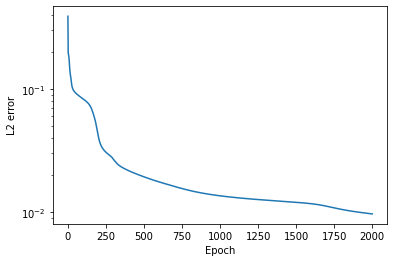

In [2]:
for epoch in range(MAX_EPOCH+1): # training
    l2 = ml.UpdateWeight()
    if(epoch%OUT_EPOCH == 0): print("Epoch %5d - L2 error: %e" % (epoch, l2))

fig, ax = plt.subplots() # show training process
ax.plot(ml.l2)
ax.set_xlabel("Epoch")
ax.set_ylabel("L2 error")
ax.set_yscale('log')
plt.show()

### evaluation test

Test data - L2 error: [0.01128516]
Test data - correct rate: 0.99

 w_ij = 
 [[ 26.35107303  27.02930728 -21.84808999 -20.62690478]]

 w_jk = 
 [[  3.96892687  -3.66725969   8.34903701  -1.9639375 ]
 [  5.84728301  -3.1327005   -4.09654529  -6.38630242]
 [ 10.7607825    4.7580293    7.35317675 -17.31514916]
 [ 12.67045247 -17.82573854   4.77997373   6.8331631 ]]

 w_kl = 
 [[-2.85182761  0.63852996]
 [ 1.27107523  1.82619013]
 [ 9.33637723 -1.07234034]
 [ 1.48237502 -1.52085014]]


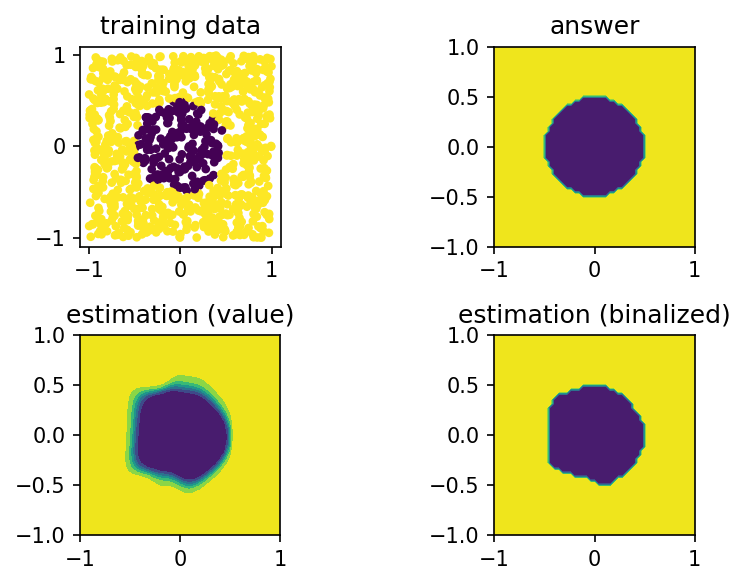

In [3]:
# test
test = np.loadtxt(url + TYPE + "/test.dat") # read test data
numTestData = test.shape[0]
tx, ty, label = test[:, 0], test[:, 1], test[:, 2]

l2 = 0.0 # initialize L2 error
count = 0
y   = np.array([])
zis = np.array([])

for td in test: 
    # forward
    zi, zj, zk, zl = ml.Forward([td[0], td[1]])

    ti = td[2]              # read test data
    yi = 1.0 if zi > 0.5 else 0.0

    y = np.append(y, yi)
    zis = np.append(zis, zi)

    # add l2 error
    l2 += (zi - ti)**2.0/numTestData
    count += 1 if ti == yi else 0

print("Test data - L2 error:", l2)
print("Test data - correct rate: %.2f" % (count/numTestData))

print("\n w_ij = \n", ml.w_ij)
print("\n w_jk = \n", ml.w_jk)
print("\n w_kl = \n", ml.w_kl)

# show training data
fig, ax = plt.subplots(2, 2)
fig.set_dpi(150)
ax[0,0].scatter(ml.data[:ml.numData, 0], ml.data[:ml.numData, 1], c=ml.data[:ml.numData, 2], s = 10.0)
ax[0,0].set_aspect('equal')
ax[0,0].set_title('training data')

ax[0,1].contourf(tx.reshape(51, 51), ty.reshape(51, 51), label.reshape(51, 51), vmin=0, vmax=1)
ax[0,1].set_aspect('equal')
ax[0,1].set_title('answer')

ax[1,0].contourf(tx.reshape(51, 51), ty.reshape(51, 51), zis.reshape(51, 51), vmin=0, vmax=1)
ax[1,0].set_aspect('equal')
ax[1,0].set_title('estimation (value)')

ax[1,1].contourf(tx.reshape(51, 51), ty.reshape(51, 51), y.reshape(51, 51), vmin=0, vmax=1)
ax[1,1].set_aspect('equal')
ax[1,1].set_title('estimation (binalized)')

fig.tight_layout()
plt.show()

### show network

In [4]:
g = graphviz.Digraph()

scale = 0.2
g.attr('node', shape='circle', fontsize="9", labelfontsize="1")

for l in range(ml.num_l): 
    for k in range(ml.num_k): 
        if ml.w_kl[k, l] >= 0.0:
            g.edge('zl' + str(l), 'zk' + str(k), penwidth=str(scale*abs(ml.w_kl[k, l])), color="red")
        else:
            g.edge('zl' + str(l), 'zk' + str(k), penwidth=str(scale*abs(ml.w_kl[k, l])), color="blue")

for k in range(ml.num_k): 
    for j in range(ml.num_j): 
        if ml.w_jk[j, k] >= 0.0:
            g.edge('zk' + str(k), 'zj' + str(j), penwidth=str(scale*abs(ml.w_jk[j, k])), color="red")
        else:
            g.edge('zk' + str(k), 'zj' + str(j), penwidth=str(scale*abs(ml.w_jk[j, k])), color="blue")

for j in range(ml.num_j): 
    for i in range(ml.num_i): 
        if ml.w_ij[i, j] >= 0.0:
            g.edge('zj' + str(j), 'zi' + str(i), penwidth=str(scale*abs(ml.w_ij[i, j])), color="red")
        else:
            g.edge('zj' + str(j), 'zi' + str(i), penwidth=str(scale*abs(ml.w_ij[i, j])), color="blue")

graphviz.Source(g)

AttributeError: 'Digraph' object has no attribute 'splitlines'

### test value: change (tx, ty) and check whether the system is working correctly

In [ ]:
tx = 0.5
ty = 0.0

answer, _, _, _ = ml.Forward([tx, ty])
print(answer)